In [1]:
import os
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from math import sqrt
import wfdb

In [2]:
###### 主程式碼 poincare plot #######
def plot_poincare(rr):
    #Credit : BJORN (in Kaggle) https://www.kaggle.com/code/bjoernjostein/heart-rate-variability-hrv-analysis
    rr_n = rr[:-1] #第0個元素到倒數第2個元素
    rr_n1 = rr[1:] #第1個元素到倒數第1(最後一個)個元素

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n) #SD1的計算
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n) #SD2的計算

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)
    
    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')
    

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")
    plt.grid()
    
    return sd1, sd2

In [3]:
def rr_to_recurrence_plot(rr_peaks, time_delay = 1): #time_delay must be an INTEGER. e.g. for a poincare plot time_delay = 1
    rr_n = rr_peaks[:-time_delay].reshape(-1,1) #第0個元素到倒數第time_delay + 1 個元素
    rr_n1 = rr_peaks[time_delay:].reshape(-1,1) #第time_delay個元素到倒數第1(最後一個)個元素
    #print(rr_n)
    #print(rr_n1)
    return np.hstack([rr_n, rr_n1])

In [4]:
###### 主程式碼 stepping #######
def stepping(rr):
    rr_n = rr[:-1] #第0個元素到倒數第2個元素
    rr_n1 = rr[1:] #第1個元素到倒數第1(最後一個)個元素
    
    rrn_rrn1 = rr_n - rr_n1 # I1-I2, I2-I3, ...., I(n-2)-I(n-1), I(n-1) - I(n)
    Sum = 0 #sum_of_root_of_sum_of_2_square = 0 
    for i in range(len(rrn_rrn1)-1) : #假設資料長度是n，那麼兩兩相加
        #print("sqrt((rr {} - rr {} )**2 + (rr {} - rr {} )**2) = {}".format(i+1, i+2, i+2, i+3, sqrt(rrn_rrn1[i]**2 + rrn_rrn1[i+1]**2)))
        Sum += sqrt(rrn_rrn1[i]**2 + rrn_rrn1[i+1]**2)
    
    stepping = (Sum / (len(rr)-2) ) / (rr.sum() / len(rr))
    return stepping

In [5]:
def dispersion(sequence):
    n = len(sequence)
    diff_squared = np.sum(np.square(np.diff(sequence)))
    absolute_diff = np.sum(np.abs(np.diff(sequence)))
    dispersion = np.sqrt((1/(2*(n-1))) * diff_squared - ((1/((n-1)*np.sqrt(2))) * absolute_diff)**2) / ((1/(2*(n-1))) * (-sequence[0] - sequence[n-1] + 2*np.sum(sequence[:-1])))
    return dispersion


In [6]:
#參考至chatgpt生成程式碼
######## 主程式 畫cluster ################
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def plot_cluster(X, labels):
    """在上述程式碼中，我們使用 matplotlib.cm 模組的 rainbow 函數生成一個顏色映射，該映射根據分群數量平均分配顏色。使用 np.linspace 函數來指定顏色映射的範圍。接著，我們使用 colors[labels[index]] 選擇對應的顏色，並將其應用於散點圖的顏色。

    這種方法可以根據分群數量動態生成更多的顏色，因此可以適應更多的分群情況。您還可以根據需要選擇其他的預定義顏色映射，或者自訂一個顏色列表。
    """

    unique_labels = set(labels)

    colors = cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    for index in range(len(labels)): 
        if labels[index] == -1:
            plt.scatter(X[index, 0], X[index, 1], color='b', marker='o')
        else:
            label_color = colors[labels[index]]
            plt.scatter(X[index, 0], X[index, 1], color=label_color, marker='o')
    plt.xlim(0, 1500)
    plt.ylim(0, 1500)
    plt.grid()
    plt.show()
    return 

In [7]:
from sklearn.cluster import DBSCAN
import numpy as np
def poincare_clustering_3(rr,epslion,num_of__min_samples):
        
    rr_n = rr[:-1] #第0個元素到倒數第2個元素
    rr_n1 = rr[1:] #第1個元素到倒數第1(最後一個)個元素
    X = np.concatenate((rr_n.reshape(len(rr_n),1),rr_n1.reshape(len(rr_n1),1)), axis=1)
    
    db = DBSCAN(eps=epslion, min_samples=num_of__min_samples).fit(X)  #eps=100, min_samples=10
    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    return n_clusters_, labels

In [41]:
##############主程式碼1 的資料處裡自動化###################
def preprocessing_data(ndarray_of_a_signal, sampling_freq): 
    """
    ndarray_of_a_signal : a 1 dimensional ndarray.
    """
    # Detrending
    detrended_signal = nk.signal_detrend(ndarray_of_a_signal, order="auto")
    

    #注意!!!!!有些peak會抓不準，例如n20，從而導致偽陽性。
    ecg_clean = nk.ecg_clean( detrended_signal, sampling_rate=128, method='neurokit') #記得先用reshape拉長 #因為record.p_signal是一個(38400(或230400), 1)的array，其實也就是兩層中括號，所以要拉成1維的。


    record_to_Series = pd.Series(ecg_clean)#detrended_clean_signal 
    record_to_Series.size #沒有c結尾檔名的長度 : 230400 = 128hz * 60sec * 30min = 30分鐘的訊號 ； c結尾檔名的長度 : 38400  = 128hz * 60sec * 5 min = 5分鐘的訊號。
    #奇數編號的記錄（例如 p15）包含遠離PAF的30分鐘ECG記錄；每對30分鐘記錄中的第二個（偶數編號ex p16）記錄包含在PAF發作之前的ECG記錄，可以通過檢查相同編號的延續記錄來驗證。


    #distance=sampling rate*(30/60))= sampling rate*(一分鐘30下/60秒))，至於prominence=0.01是原作者試出來的
    peaks_ECG, info = nk.ecg_peaks(record_to_Series, sampling_rate=128, method='neurokit2', correct_artifacts=False) #method='rodrigues2021'
    peak_locations = info['ECG_R_Peaks']


    rr_ECG = np.diff(peak_locations)
    corr_rr_ECG = rr_ECG*(1000/sampling_freq) #Sampling rate 是128HZ意思就是1秒sampling 128次，也就是說1秒的時間被分成了128等分，又1秒=1000毫秒，所以點跟點之間實際上差了1000/128毫秒。
    
    return corr_rr_ECG


In [9]:
######將wfdb 檔 load data 成 DataFrame的過程自動化##########
def import_data():
    data_list = []  # 儲存每個檔案的資料
    N = 50
    for i in range(1, N+1):  # 讀取 n01 到 n50 的檔案
        record_name = 'p{:02d}'.format(i)  # 根據命名規則生成檔案名稱
        record_path = os.path.abspath('D:/kaggle/paf-prediction-challenge-database-1.0.0/' + record_name)

        # 讀取檔案並獲取所需通道的資料
        record = wfdb.rdrecord(record_path, channels=[0]) #有兩個channel ，讀取第0個
        data = record.p_signal.flatten() #我把一個ndarray化做一個1維向量
        print(data)
        # 將資料添加到列表中
        data_list.append(data)
        
        # 將列表轉換為 DataFrame
        df = pd.DataFrame(data_list)
        
    return df, record.fs

In [10]:
def bulk_preprocessing(file_name):
    sampling_freq = 128 #可由record.fs的值決定
    df_csv = pd.read_csv("D:/kaggle/"+file_name, index_col=0) #第0個column作為index，所以index_col=0
    
    list_of_rr =[]
    list_of_labels = []
    
    for i in range(df_csv.shape[0]): #例如 : df_normal.shape[0]表示"row"的數量；df_normal.shape[1]表示"column"的數量
        rr = df_csv.iloc[i].array
        processed_signal = preprocessing_data(rr[:-1],sampling_freq)
        list_of_rr.append(processed_signal)
        list_of_labels.append(rr[-1])
        
    return list_of_rr, list_of_labels #Return a list of each patient(normal) RR intervals and a list of labels

In [11]:
list_of_normal_rr, list_of_normal_labels = bulk_preprocessing("paf_50normal_ECG_data.csv")
print("list_of_normal_rr=",len(list_of_normal_rr))
print("list_of_normal_labels=", len(list_of_normal_labels))


list_of_normal_rr= 50
list_of_normal_labels= 50


In [25]:
num1 = 2
list_of_normal_rr[num1]

array([640.625 , 632.8125, 632.8125, ..., 695.3125, 703.125 , 703.125 ])

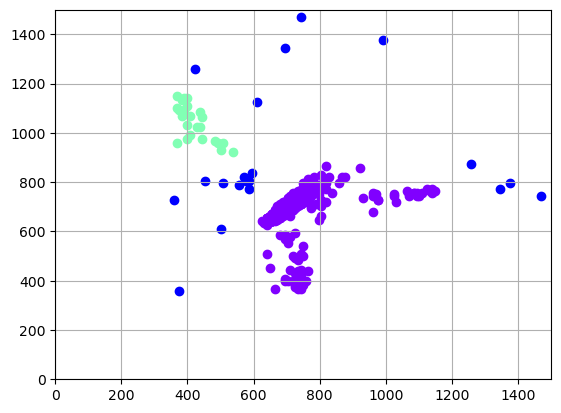

In [26]:
n_clusters_, labels = poincare_clustering_3(list_of_normal_rr[num1],100,10) #20

plot_cluster(rr_to_recurrence_plot(list_of_normal_rr[num1]),labels)

(62.70254807729767, 61.558917786293684)

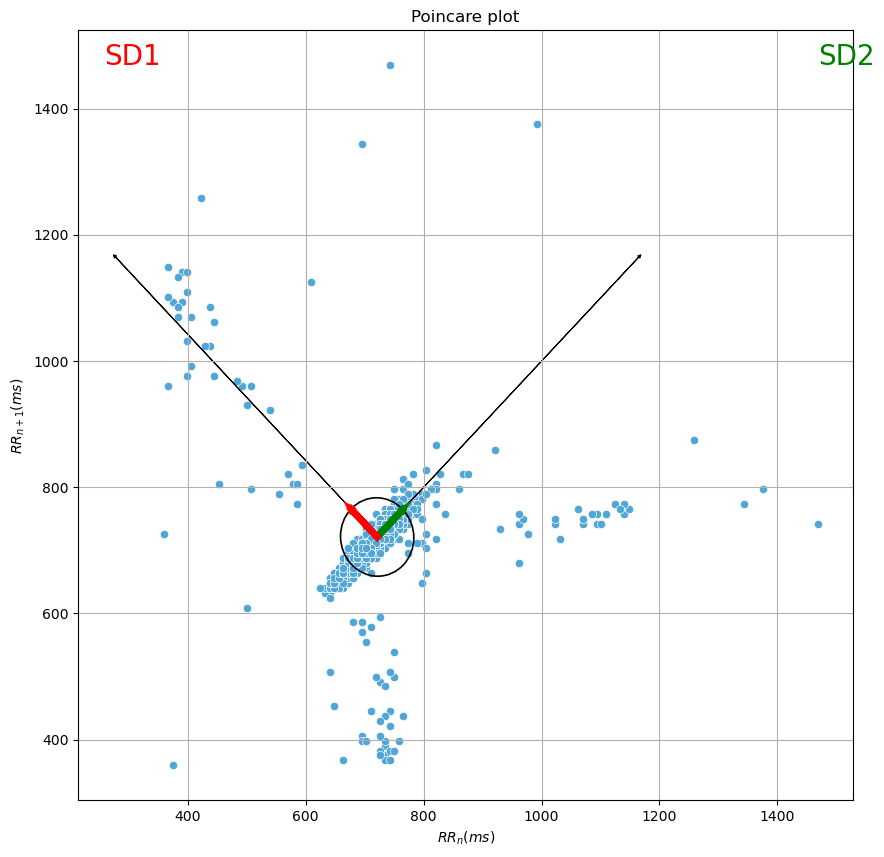

In [27]:
plot_poincare(list_of_normal_rr[num1])

In [15]:
list_of_patients_rr, list_of_patients_labels = bulk_preprocessing("paf_50patients_ECG_data.csv")
print("list_of_patients_rr=",len(list_of_patients_rr))
print("list_of_patients_labels=", len(list_of_patients_labels))

list_of_patients_rr= 50
list_of_patients_labels= 50


In [28]:
num2 = 2
list_of_patients_rr[num2]

array([648.4375, 656.25  , 656.25  , ..., 640.625 , 632.8125, 640.625 ])

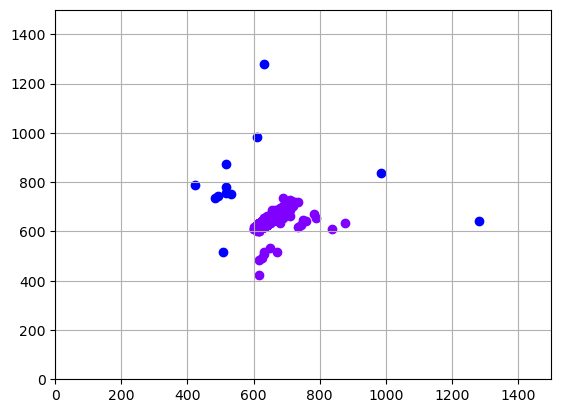

In [29]:

n_clusters_, labels = poincare_clustering_3(list_of_patients_rr[num2],100,10)

plot_cluster(rr_to_recurrence_plot(list_of_patients_rr[num2]),labels)

(30.084556892732365, 37.35537936625996)

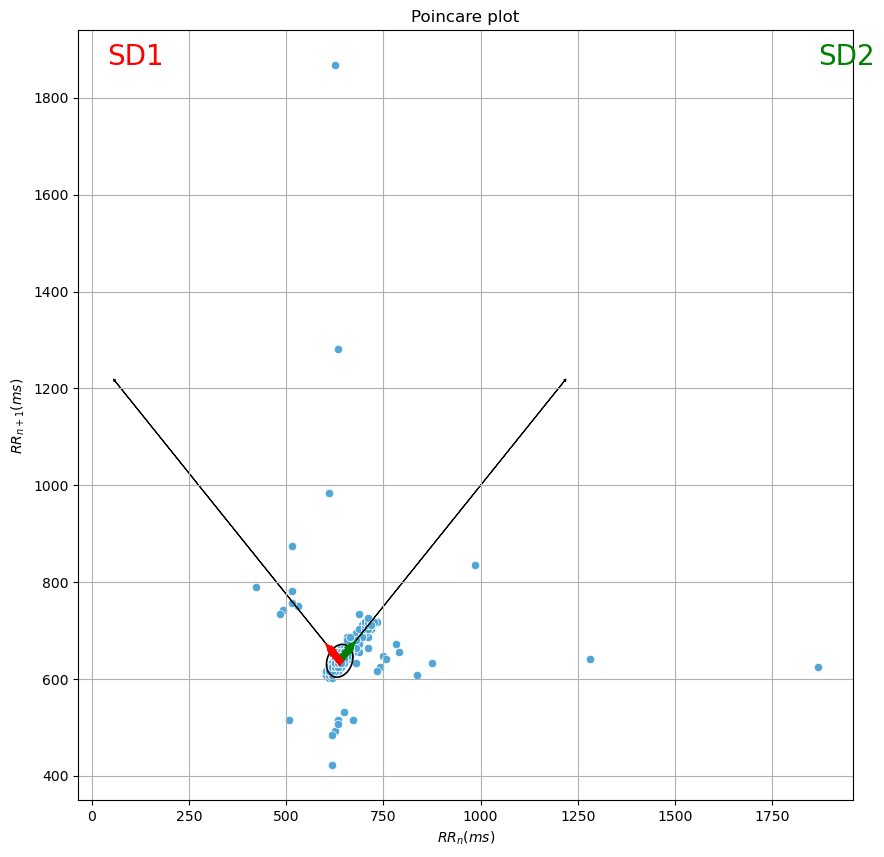

In [30]:
plot_poincare(list_of_patients_rr[num2])

In [19]:
#########由預處理陣列讀取的 資料預處理自動化 3 #################
def featuring(list_rr, list_labels, eps, min_samples):
    #file_name = "paf_50normal_ECG_data.csv"
    
    sampling_freq = 128 #可由record.fs的值決定

    df_read_in = pd.DataFrame({'n_clusters' : [],'Stepping' : [], 'Dispersion' : [], 'Labels' : []})
    for i in range(len(list_rr)): #例如 : df_normal.shape[0]表示"row"的數量；df_normal.shape[1]表示"column"的數量
        processed_signal = list_rr[i]
        n_clusters_, labels = poincare_clustering_3(processed_signal,eps, min_samples) #eps=100, min_samples=10
        new_row = pd.DataFrame({'n_clusters' : n_clusters_, 'Stepping': stepping(processed_signal), 'Dispersion' : dispersion(processed_signal), 'Labels' : int(list_labels[i])}, index=[0])
        df_read_in = pd.concat([df_read_in, new_row],ignore_index = True)

    #display(df_read_in)
    return df_read_in

In [34]:
def renew_feature_CSV_2(list_of_normal_rr, list_of_normal_labels, list_of_patients_rr, list_of_patients_labels, eps, min_samples): 
    
    df_normal = featuring(list_of_normal_rr, list_of_normal_labels, eps, min_samples)
    df_patients = featuring(list_of_patients_rr, list_of_patients_labels, eps, min_samples)
    df_paf = pd.concat([df_normal, df_patients],ignore_index = True)
    df_paf.to_csv("D:/kaggle/paf_featured_ECG_data.csv")
    return df_paf

In [40]:
paf_features = renew_feature_CSV_2(list_of_normal_rr, list_of_normal_labels, list_of_patients_rr, list_of_patients_labels, 100, 10) #250,300
for i in paf_features.index:
    print(paf_features.loc[i].values)

[1.         0.01240233 0.00635312 0.        ]
[1.         0.01219038 0.00515225 0.        ]
[2.         0.05449785 0.0835922  0.        ]
[4.         0.11461023 0.15294863 0.        ]
[1.         0.0135562  0.00570327 0.        ]
[1.         0.02320585 0.01217575 0.        ]
[4.         0.13100465 0.10734793 0.        ]
[1.         0.01023943 0.01607514 0.        ]
[5.         0.37962292 0.25257942 0.        ]
[3.         0.12907174 0.12640168 0.        ]
[4.         0.04005346 0.04954441 0.        ]
[2.         0.04734905 0.05263203 0.        ]
[1.         0.02822702 0.01816906 0.        ]
[1.         0.01466356 0.00798537 0.        ]
[1.         0.09474709 0.09046384 0.        ]
[1.         0.14582182 0.10833315 0.        ]
[3.         0.04147166 0.05305387 0.        ]
[1.         0.0257003  0.01517449 0.        ]
[4.         0.27900386 0.17081774 0.        ]
[5.         0.2701489  0.16566045 0.        ]
[1.         0.15800679 0.10978203 0.        ]
[3.         0.3373309  0.32165297 

Confusion matrix, without normalization
[[ 9  4]
 [ 2 10]]
Normalized confusion matrix
[[0.69230769 0.30769231]
 [0.16666667 0.83333333]]


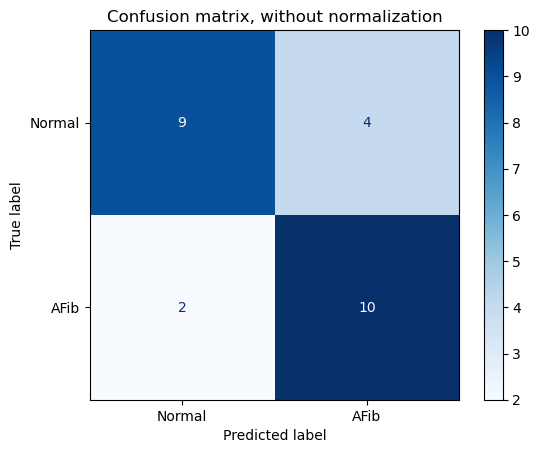

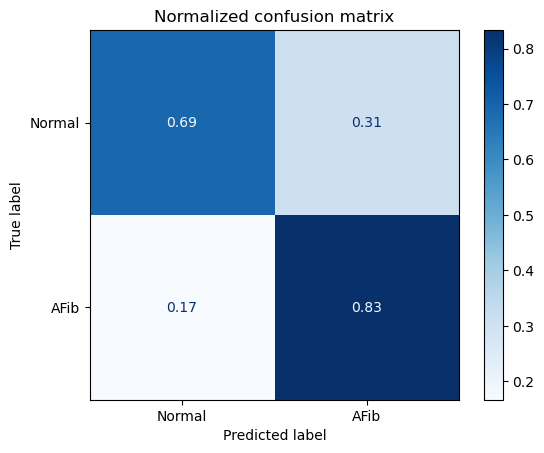

In [36]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


# import some data to play with
X = paf_features.values[:,:3] #training set
y = paf_features.values[:,3] #labels
class_names = ["Normal","AFib"] #string array, ["species 1", "species 2", "species 3", ...]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) #training set and labels

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel="rbf",gamma=100, C=20).fit(X_train, y_train) #gamma=100, C=126

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

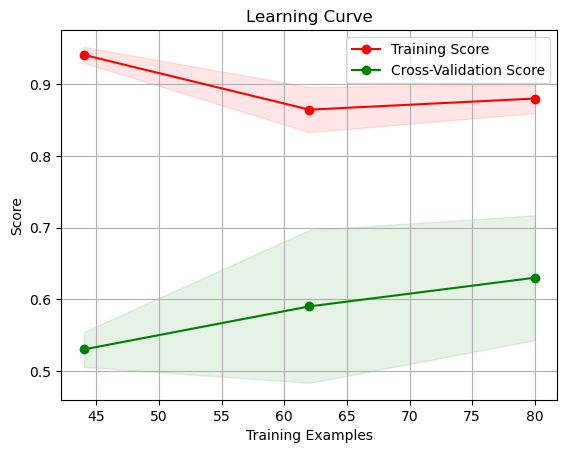

In [37]:
#程式碼參考自sklearn documantation 的example : https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Compute the learning curve scores
train_sizes, train_scores, test_scores = learning_curve(classifier, X, y, cv=5)

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

# Plot the training scores with error bars
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training Score")

# Plot the cross-validation scores with error bars
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()
